In [1]:
# %load ../config/defaults.py
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dask.delayed import delayed
from dask.distributed import Client
import dask.dataframe as dd

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook()

# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

# Dask server
client = Client()
client

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-03-09 
Git hash: 481186bc23484439db5d199bf22411933a1bca80


Client Scheduler: tcp://127.0.0.1:38450 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 22.99 GB


In [2]:
store.root.prealn.workflow.collectrnaseqmetrics

/prealn/workflow/collectrnaseqmetrics (Group) ''
  children := ['first' (Group), 'genebody' (Group), 'second' (Group), 'unstranded' (Group)]

In [3]:
# Select SRXs that passed QC and are in the complete
prepass = store['prealn/merge_passed'].srx.unique()
ready_srx = store.select('aln/complete', 'srx == prepass').srx.unique()

In [4]:
first_strand = store.select('prealn/workflow/collectrnaseqmetrics/first', 'srx == ready_srx & PCT_CORRECT_STRAND_READS >= .99').index.get_level_values('srx').tolist()
second_strand = store.select('prealn/workflow/collectrnaseqmetrics/second', 'srx == ready_srx & PCT_CORRECT_STRAND_READS >= .99').index.get_level_values('srx').tolist()
stranded = set(first_strand)
stranded |= set(second_strand)

In [5]:
fnames = []
for srx in stranded:
    fnames.append(f'../aln-wf/output/junction_counts/{srx}.parquet')

In [6]:
dfs = dd.read_parquet(fnames)
dfs_chrom = dfs.query('Site1_chr == Site2_chr').persist()

In [10]:
grps = dfs_chrom.groupby(['Site1_chr', 'Site1_location', 'Site2_location', 'PrimaryGene'])

In [12]:
totals = grps['count'].sum().compute()
counts = grps['count'].count().compute()

/data/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


In [13]:
counts.head()

Site1_chr  Site1_location  Site2_location  PrimaryGene
chr2L      10545           10952           FBgn0002121       1
           11169           11230           FBgn0002121      83
           11344           11410           FBgn0002121    1413
                           11779           FBgn0002121     271
           11345           11412           FBgn0002121      15
Name: count, dtype: int64

In [14]:
dfs_chrom.query('Site1_chr == "chr2L" & Site1_location == 11345').compute()

/data/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


,PrimaryGene,Site1_chr,Site1_location,Site1_strand,Site2_chr,Site2_location,Site2_strand,count,srx
269,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX792878
100,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX1491300
50,FBgn0002121,chr2L,11345,NaN,chr2L,11413,NaN,1,SRX1637700
141,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX2540526
9,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,2,SRX029396
217,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX823556
61,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX161007
189,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX2540527
65,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,1,SRX1054691
60,FBgn0002121,chr2L,11345,NaN,chr2L,11412,NaN,2,SRX045354


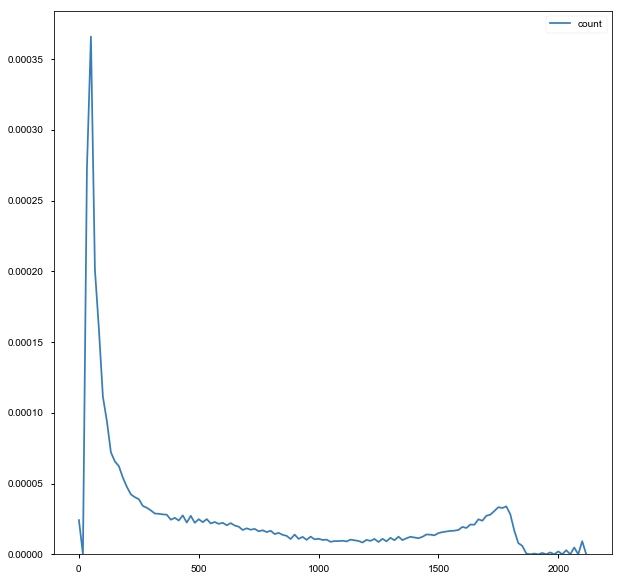

In [20]:
fig = plt.figure(figsize=(10,10))
sns.kdeplot(counts[counts != 0])

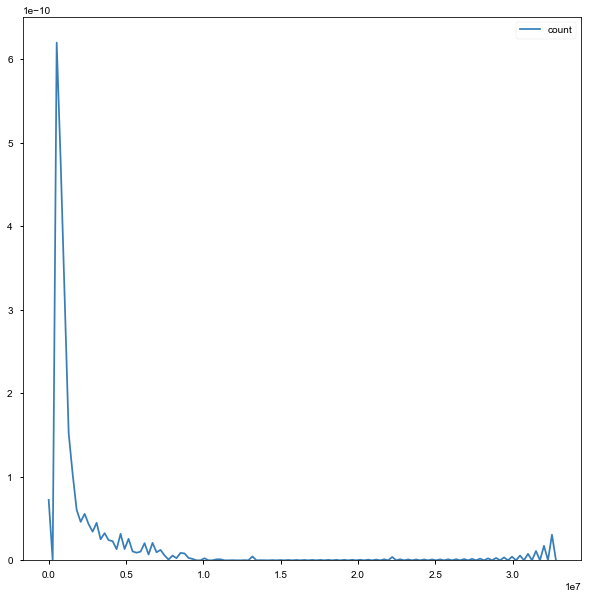

In [22]:
fig = plt.figure(figsize=(10, 10))
sns.kdeplot(totals)